In [46]:
# %pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import json
import requests

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Experiment set 1

In [131]:
df = pd.read_csv('../output/Meal_plan_with_calories(15Nov).csv')
ingredient_df = pd.read_csv('../output/DB_Import_macros_n_micros_v21_bug_fix.csv')
recipe_df = pd.read_csv('../output/recipe.csv')
nin_ingredients_df = pd.read_csv('../input/nin_ingredient.csv', usecols=['id', 'ingredient_name'])
nin_ingredients_df = nin_ingredients_df.rename(columns={
    'id': 'nin_id', 
    'ingredient_name': 'nin_ingredient_name'
    })

In [132]:
nin_ingredients_df

,nin_id,nin_ingredient_name
0,1,"Amaranth seed, black"
1,2,"Amaranth seed, pale brown"
2,3,Bajra
3,4,Barley
4,5,Jowar
...,...,...
588,584,Pecan
589,586,Oyster sauce
590,588,Milk powder
591,590,Star anise


In [133]:
df.columns

Index(['plan_id', 'plan_name', 'day', 'meal_time', 'meal_no', 'recipe_id',
       'recipe_name', 'energy', 'per_serving_wt', 'total_serving_wt',
       'serving_qty', 'serving_unit'],
      dtype='object')

In [134]:
# Separate veg and non-veg diets

non_veg_diets = veg_diets = pd.DataFrame()
for plan_name, plan_df in df.groupby('plan_name'):
    meal_cals = {'plan_name': plan_name}
    for meal_name, meal_time_df in plan_df.groupby('meal_time'):
        meal_cals[meal_name] = meal_time_df['energy'].mean()
    if 'non_veg' in plan_name:
        non_veg_diets = non_veg_diets.append(meal_cals, ignore_index=True)
    else:
        veg_diets = veg_diets.append(meal_cals, ignore_index=True)


In [135]:
recipe_df.columns

Index(['id', 'recipe_name', 'image_path', 'course', 'cusine', 'recipe_url',
       'website_name', 'serving', 'deleted', 'updated_by', 'create_at',
       'updated_at', 'default_serving_unit_id'],
      dtype='object')

In [136]:
plan_wise_ingredients = pd.DataFrame()
recipe_quantities = recipe_ingredient_names = recipe_macros = None
for plan_name, plan_df in df.groupby('plan_name'):
    for plan_index, plan_row in plan_df.iterrows():
        recipe_id = plan_row['recipe_id']
        plan_id = plan_row['plan_id']
        plan_name = plan_row['plan_name']
        recipe_ing_df = ingredient_df[ingredient_df['recipe_id'] == recipe_id]

        # verify this calculation
        recipe_ing_df['quantity_in_gram'] = recipe_ing_df['quantity_in_gram'] * plan_row['serving_qty'] / recipe_df[recipe_df['id'] == recipe_id]['serving'].values[0]
        recipe_ing_df['plan_id'] = plan_id
        recipe_ing_df['plan_name'] = plan_name
        frames = [plan_wise_ingredients, recipe_ing_df]
        plan_wise_ingredients = pd.concat(frames)

In [137]:
# use this df to get how many times ingredients get repeated across various plans
plan_wise_ingredients.head()

,id,recipe_id,nin_id,ingredient_name,ingredient_standard_name,ingredient_desc,quantity,quantity_in_gram,serving_unit_id,serving_unit,macros,micros,updated_by,create_at,updated_at,plan_id,plan_name
1238,39,32,238.0,onion,onion,"large onion, sliced",1.0,4.000000,4.0,cup,"{'protein': 3.28, 'total fat': 0.29, 'fiber': ...","{'calcium': 0.04, 'iron': 0.0, 'manganese': 0....",NaN,2022-09-09 09:31:38.119018,NaN,6,diabetes-north-non_veg
1358,41,32,515.0,sugar,sugar,NaN,1.0,0.111111,10.0,tsp,"{'protein': 0.0, 'total fat': 0.0, 'fiber': 0....","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-09 09:31:38.119023,NaN,6,diabetes-north-non_veg
1599,42,32,517.0,salt,salt,salt to taste,0.0,0.000000,30.0,NaN,"{'protein': 0.0, 'total fat': 0.0, 'fiber': 0....","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-09 09:31:38.119026,NaN,6,diabetes-north-non_veg
1963,43,32,228.0,green chillies,green chillies,4-6 green chilli,4.0,0.088889,30.0,NaN,"{'protein': 0.09, 'total fat': 0.03, 'fiber': ...","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-09 09:31:38.119028,NaN,6,diabetes-north-non_veg
2349,37,32,236.0,chopped mint leaves,mint leaves,chopped mint leaves,2.0,8.000000,4.0,cups,"{'protein': 16.78, 'total fat': 2.34, 'fiber':...","{'calcium': 0.74, 'iron': 0.03, 'manganese': 0...",NaN,2022-09-09 09:31:38.119010,NaN,6,diabetes-north-non_veg


In [ ]:
plan_wise_ingredients

In [138]:
def ingredient_plan_correlation(plan_wise_ingredients, nin_id):
    df_temp = plan_wise_ingredients[plan_wise_ingredients['nin_id'] == nin_id]
    return df_temp['plan_name'].value_counts()

In [142]:
ingredient_plan_correlation(plan_wise_ingredients, 30)

thyroid-south-non_veg    1
thyroid-south-veg        1
weight_loss-south-veg    1
Name: plan_name, dtype: int64

In [129]:
# plan_names = df['plan_name'].unique()
# nans = [np.nan] * len(plan_names)
# plan_wise_ingredients[plan_names] = pd.DataFrame([nans], index=df.index)

# # for nin_id, ing_df in plan_wise_ingredients.groupby('nin_id'):  # unique ingredient
# #     for plan_name, plan_df in ing_df.groupby('plan_name'):  # individual ingredient used across various plans
# #         plan_wise_ingredients.loc[plan_df['id'] == ing_df['id']] = len(plan_df)

In [126]:
ing_df.iloc[:5, :17]

,id,recipe_id,nin_id,ingredient_name,ingredient_standard_name,ingredient_desc,quantity,quantity_in_gram,serving_unit_id,serving_unit,macros,micros,updated_by,create_at,updated_at,plan_id,plan_name
1739,953,123,3.0,bajra flour,bajra flour,(black millet),0.5,2.8125,4.0,cup,"{'protein': 4.93, 'total fat': 2.44, 'fiber': ...","{'calcium': 0.01, 'iron': 0.0, 'manganese': 0....",NaN,2022-09-21 05:42:28.325554,NaN,6,diabetes-north-non_veg
1967,964,123,3.0,bajra flour,bajra flour,(to be mixed into a topping),0.5,0.1875,10.0,tsp,"{'protein': 0.33, 'total fat': 0.16, 'fiber': ...","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-21 05:42:28.325582,NaN,6,diabetes-north-non_veg
1620,2477,247,3.0,black millet flour,black millet flour,NaN,0.5,0.1500,10.0,tsp,"{'protein': 0.33, 'total fat': 0.16, 'fiber': ...","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-22 15:27:48.493782,NaN,9,hypertension-north-non_veg
1989,2465,247,3.0,black millet flour,black millet flour,NaN,0.5,2.2500,4.0,cup,"{'protein': 4.93, 'total fat': 2.44, 'fiber': ...","{'calcium': 0.01, 'iron': 0.0, 'manganese': 0....",NaN,2022-09-22 15:27:48.449996,NaN,9,hypertension-north-non_veg
1620,2477,247,3.0,black millet flour,black millet flour,NaN,0.5,0.1500,10.0,tsp,"{'protein': 0.33, 'total fat': 0.16, 'fiber': ...","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-22 15:27:48.493782,NaN,9,hypertension-north-non_veg


In [116]:
plan_df

,id,recipe_id,nin_id,ingredient_name,ingredient_standard_name,ingredient_desc,quantity,quantity_in_gram,serving_unit_id,serving_unit,...,weight_loss-south-veg,muscle_gain-north-non_veg,muscle_gain-north-veg,muscle_gain-south-non_veg,muscle_gain-south-veg,thyroid-north-non_veg,thyroid-north-veg,thyroid-south-non_veg,thyroid-south-veg,i
1739,953,123,3.0,bajra flour,bajra flour,(black millet),0.5,2.8125,4.0,cup,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1967,964,123,3.0,bajra flour,bajra flour,(to be mixed into a topping),0.5,0.1875,10.0,tsp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [115]:
plan_wise_ingredients

,id,recipe_id,nin_id,ingredient_name,ingredient_standard_name,ingredient_desc,quantity,quantity_in_gram,serving_unit_id,serving_unit,...,weight_loss-south-veg,muscle_gain-north-non_veg,muscle_gain-north-veg,muscle_gain-south-non_veg,muscle_gain-south-veg,thyroid-north-non_veg,thyroid-north-veg,thyroid-south-non_veg,thyroid-south-veg,i
1238,39,32,238.0,onion,onion,"large onion, sliced",1.00,4.000000,4.0,cup,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1358,41,32,515.0,sugar,sugar,NaN,1.00,0.111111,10.0,tsp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1599,42,32,517.0,salt,salt,salt to taste,0.00,0.000000,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1963,43,32,228.0,green chillies,green chillies,4-6 green chilli,4.00,0.088889,30.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2349,37,32,236.0,chopped mint leaves,mint leaves,chopped mint leaves,2.00,8.000000,4.0,cups,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,54,34,552.0,vinegar,vinegar,red wine vinegar,0.25,2.250000,4.0,cup,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3072,53,34,516.0,olive oil,olive oil,extra-virgin olive oil,0.25,2.250000,4.0,cup,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3073,56,34,137.0,tomatoes,tomatoes,"tomatoes, chopped",2.00,18.000000,4.0,cup,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3234,52,34,553.0,pasta,pasta,tri-color rotini pasta (Optional),2.00,18.000000,4.0,cups,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [78]:
# new_df = pd.DataFrame()
# recipe_quantities = recipe_ingredient_names = recipe_macros = None
# for plan_name, plan_df in df.groupby('plan_name'):      # every diet plan - muscle gain north veg
#     for meal_name, meal_time_df in plan_df.groupby('meal_time'):    # every meal time - breakfast
#         for meal_index, meal_row in meal_time_df.iterrows():    # every meal in breakfast - roti, chutney
#             recipe_id = meal_row['recipe_id']
#             recipe_ing_df = ingredient_df[ingredient_df['recipe_id'] == recipe_id]

#             # verify this calculation
#             recipe_ing_df['quantity_in_gram'] = recipe_ing_df['quantity_in_gram'] * meal_row['serving_qty'] / recipe_df[recipe_df['id'] == recipe_id]['serving'].values[0]
#             frames = [new_df, recipe_ing_df]
#             new_df = pd.concat(frames)


In [13]:
# new_df = pd.DataFrame()
# recipe_quantities = recipe_ingredient_names = recipe_macros = None
# plan_df = df[df['plan_name'] == 'thyroid-south-veg']

# for meal_name, meal_time_df in plan_df.groupby('meal_time'):    # every meal time - breakfast
#     for meal_index, meal_row in meal_time_df.iterrows():    # every meal in breakfast - roti, chutney
#         recipe_id = meal_row['recipe_id']
#         recipe_ing_df = ingredient_df[ingredient_df['recipe_id'] == recipe_id]

#         # verify this calculation
#         recipe_ing_df['quantity_in_gram'] = recipe_ing_df['quantity_in_gram'] * meal_row['serving_qty'] / recipe_df[recipe_df['id'] == recipe_id]['serving'].values[0]
#         frames = [new_df, recipe_ing_df]
#         new_df = pd.concat(frames)

In [14]:
new_df.head()

,id,recipe_id,nin_id,ingredient_name,ingredient_standard_name,ingredient_desc,quantity,quantity_in_gram,serving_unit_id,serving_unit,macros,micros,updated_by,create_at,updated_at
573,2297,234,38.0,split black lentils,split black lentils,soaked,0.5,12.000000,4.0,cup,"{'protein': 20.24, 'total fat': 0.58, 'fiber':...","{'calcium': 0.07, 'iron': 0.01, 'manganese': 0...",NaN,2022-09-22 15:27:25.816333,NaN
575,2301,234,524.0,baking soda,baking soda,NaN,1.0,0.133333,28.0,pinch,"{'protein': 0.0, 'total fat': 0.0, 'fiber': 0....","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-22 15:27:25.831673,NaN
1690,2300,234,517.0,salt,salt,NaN,0.5,0.266667,10.0,tsp,"{'protein': 0.0, 'total fat': 0.0, 'fiber': 0....","{'calcium': 0.0, 'iron': 0.0, 'manganese': 0.0...",NaN,2022-09-22 15:27:25.827863,NaN
1950,2298,234,15.0,rice semolina,rice semolina,NaN,1.0,24.000000,4.0,cup,"{'protein': 14.29, 'total fat': 0.94, 'fiber':...","{'calcium': 0.01, 'iron': 0.0, 'manganese': 0....",NaN,2022-09-22 15:27:25.820742,NaN
1964,3472,234,NaN,water,water,NaN,0.0,26.666667,1.0,NaN,"{'protein': 0, 'total fat': 0, 'fiber': 0, 'ca...","{'calcium': 0, 'iron': 0, 'manganese': 0, 'pot...",NaN,2022-11-14 11:14:13.081943,NaN


In [ ]:
new_df = pd.merge(new_df, nin_ingredients_df, on='nin_id')

<AxesSubplot: >

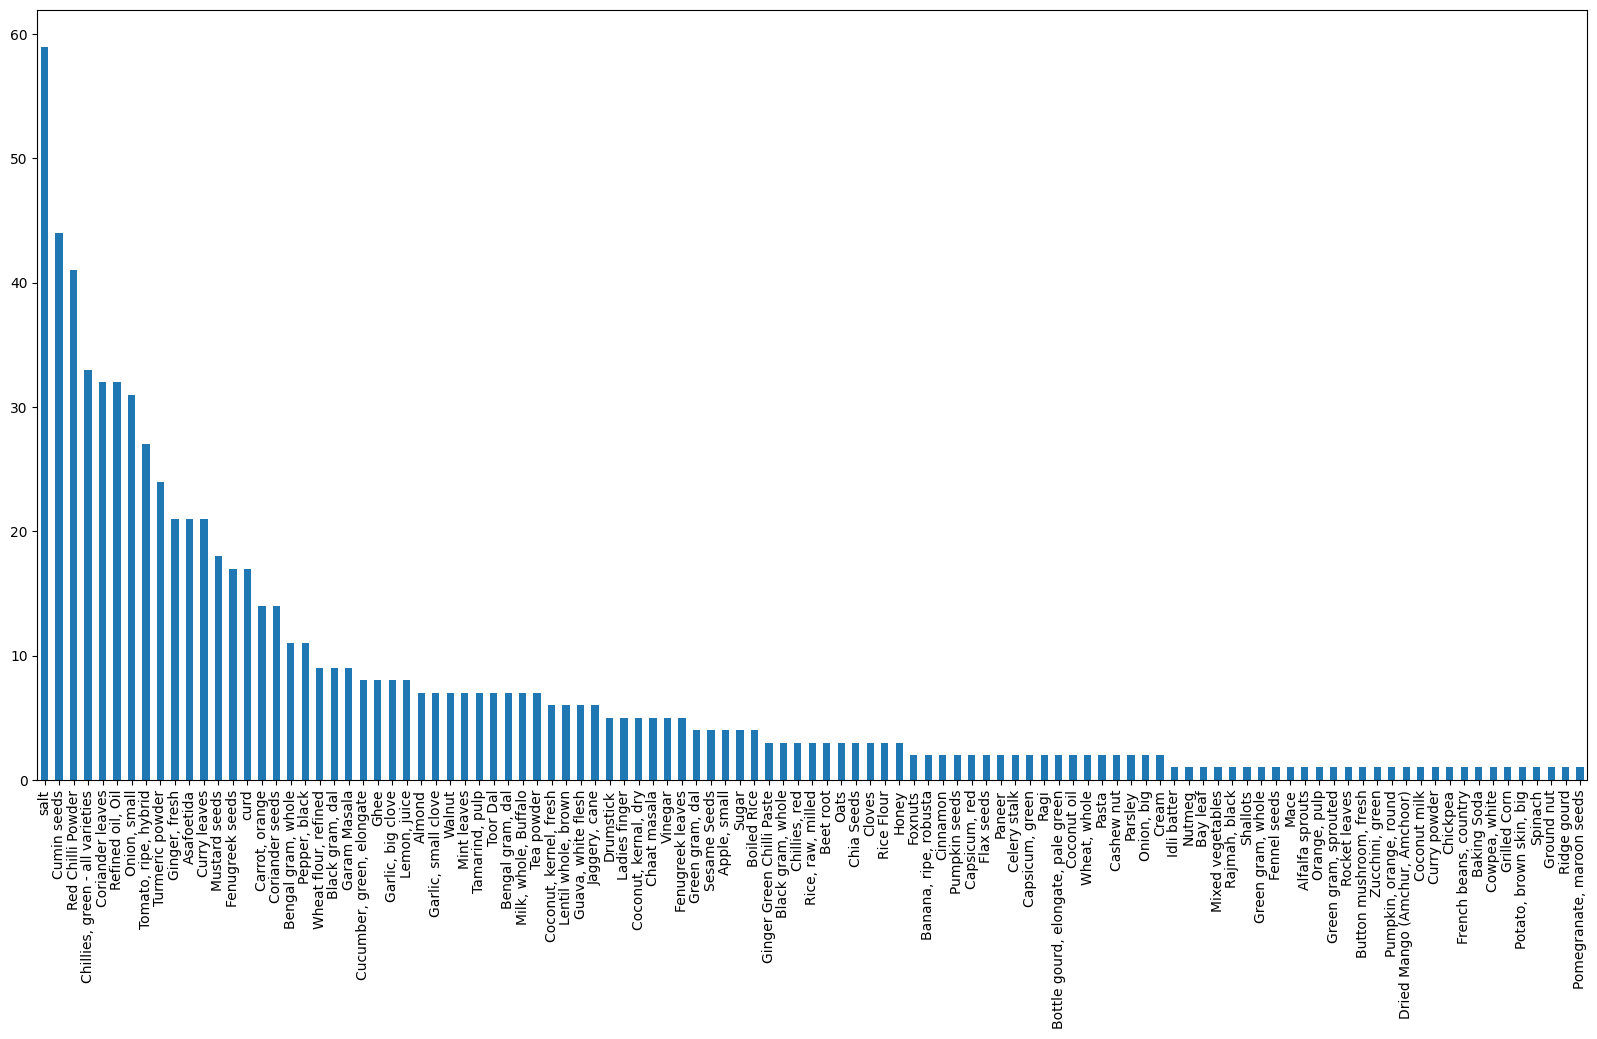

In [38]:
new_df['nin_ingredient_name'].value_counts().plot(kind='bar', figsize=(20, 10))

In [41]:
df2 = pd.DataFrame()
for val, cnt in new_df['nin_ingredient_name'].value_counts().iteritems():
    qty_sum = new_df[new_df['ingredient_name'] == val]['quantity_in_gram'].sum()
    df2 = df2.append({
        'nin_ingredient': val,
        'count': cnt,
        'qty_sum': qty_sum
    }, ignore_index=True)


In [42]:
df2

,nin_ingredient,count,qty_sum
0,salt,59,16.228463
1,Cumin seeds,44,3.666667
2,Red Chilli Powder,41,1.666667
3,"Chillies, green - all varieties",33,0.000000
4,Coriander leaves,32,10.000000
...,...,...,...
102,"Potato, brown skin, big",1,0.000000
103,Spinach,1,0.000000
104,Ground nut,1,0.000000
105,Ridge gourd,1,0.000000


### Classification based on ingredient availability

In [39]:
nin_df = pd.read_csv('../input/nin_ingredient.csv', usecols=['id', 'ingredient_name'])
nin_df = nin_df.rename(columns={
    'id': 'nin_id', 
    'ingredient_name': 'nin_ingredient_name'
    })

ingredient_df = pd.read_csv('../output/DB_Import_macros_n_micros_v21_bug_fix.csv')
ingredient_df = ingredient_df[ingredient_df['nin_id'].notna()]

recipe_df = pd.read_csv('../output/recipe.csv', usecols=['id', 'recipe_name'])
df3 = pd.DataFrame(columns=nin_df['nin_id'].tolist())

df3['recipe_name'] = recipe_df['recipe_name']
df3['recipe_id'] = recipe_df['id']
df3 = df3[df3['recipe_name'].notna()]
df3 = df3.fillna(0)

for index, row in df3.iterrows():
    recipe_id = row['recipe_id']
    ingredient_nins = ingredient_df[ingredient_df['recipe_id'] == recipe_id]['nin_id']
    for ingredient_nin in ingredient_nins:
        df3.at[index, ingredient_nin] = 1

X = df3.iloc[:, :-2]
y = df3.iloc[:, -2:-1]

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier()
clf.fit(X, y);

In [46]:
df3.iloc[:1, :]

,1,2,3,4,5,6,7,8,9,10,...,580,582,584,586,588,590,592,recipe_name,recipe_id,forest-pred
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Roasted Chickpeas,339,0.0


In [47]:
x = X.iloc[:1, :]
clf.predict(x)

array(['Roasted Chickpeas'], dtype=object)

In [50]:
df3['forest-pred'] = clf.predict_proba(x)[0]
df3.sort_values('forest-pred', ascending=False).head()

,1,2,3,4,5,6,7,8,9,10,...,580,582,584,586,588,590,592,recipe_name,recipe_id,forest-pred
240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"Moong dal cheela with paneer, carrot \n& coria...",244,0.660
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Plain dosa,256,0.140
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Coriander mint chutney,32,0.040
182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Mixveg torrancurry,209,0.030
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Methi & carrort vegetable,175,0.026


### Clustering based on ingredient's availability

In [ ]:
from sklearn.cluster import KMeans

In [51]:
nin_df = pd.read_csv('../input/nin_ingredient.csv', usecols=['id', 'ingredient_name'])
nin_df = nin_df.rename(columns={
    'id': 'nin_id', 
    'ingredient_name': 'nin_ingredient_name'
    })

ingredient_df = pd.read_csv('../output/DB_Import_macros_n_micros_v21_bug_fix.csv')
ingredient_df = ingredient_df[ingredient_df['nin_id'].notna()]

recipe_df = pd.read_csv('../output/recipe.csv', usecols=['id', 'recipe_name'])
df3 = pd.DataFrame(columns=nin_df['nin_id'].tolist())

df3['recipe_name'] = recipe_df['recipe_name']
df3['recipe_id'] = recipe_df['id']
df3 = df3[df3['recipe_name'].notna()]
df3 = df3.fillna(0)

for index, row in df3.iterrows():
    recipe_id = row['recipe_id']
    ingredient_nins = ingredient_df[ingredient_df['recipe_id'] == recipe_id]['nin_id']
    for ingredient_nin in ingredient_nins:
        df3.at[index, ingredient_nin] = 1

X = df3.iloc[:, :-2]
y = df3.iloc[:, -2:-1]

In [52]:
km = KMeans(n_clusters=200, random_state=1)
km.fit(X)
predict=km.predict(X)
df3['cluster'] = pd.Series(predict, index=df3.index)

row = X.iloc[0:0, :]
a = {}
for col in X.columns:
    a[col] = 0
row = row.append(a, ignore_index=True)

In [53]:
nins = [287, 137, 95, 526, 238, 228, 234]   # fill with nin ids of ingredients you have
for nin in nins:
    row[nin] = 1

predict = km.predict(row.iloc[:, :])
df3[df3['cluster'] == predict[0]]

,1,2,3,4,5,6,7,8,9,10,...,580,582,584,586,588,590,592,recipe_name,recipe_id,cluster
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Scrambled egg with 2 egg white (masala bhurji ...,262,2
123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Egg masala bhurji,144,2
203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Masala Bhurji,200,2
259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Egg bhurji with Onion & Capsicum,193,2


### Clustering based on meal quantity, calories, cal_wt_ratio

Can be replicated with other macros like proteins

In [57]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
meal_plan_df = pd.read_csv('../output/Meal_plan_with_calories_exp.csv')
meal_plan_df = meal_plan_df.drop(columns=['day_id', 'meal_time_id', 'recipe_id'])

In [59]:
meal_plan_df['meal_set_wt'] = meal_plan_df['meal_set_cal'] = meal_plan_df['meal_set_prot'] = None
for val, cnt in meal_plan_df.meal_set.value_counts().iteritems():
    df_temp = meal_plan_df[meal_plan_df['meal_set'] == val]
    meal_plan_df['meal_set_wt'].loc[(meal_plan_df['meal_set'] == val)] = df_temp['total_serving_wt'].sum()
    meal_plan_df['meal_set_cal'].loc[(meal_plan_df['meal_set'] == val)] = df_temp['energy'].sum()
    meal_plan_df['meal_set_prot'].loc[(meal_plan_df['meal_set'] == val)] = df_temp['protein'].sum()
meal_plan_df['cal_wt_ratio'] = meal_plan_df['meal_set_cal'] / meal_plan_df['meal_set_wt']
meal_plan_df['prot_wt_ratio'] = meal_plan_df['meal_set_prot'] / meal_plan_df['meal_set_wt']
meal_plan_df.head()

,plan_id,meal_set,recipe_name,energy,protein,total_serving_wt,meal_set_wt,meal_set_cal,meal_set_prot,cal_wt_ratio,prot_wt_ratio
0,1,1,Dal Paratha,332.35,12.01,112.18,141.89,342.67,13.02,2.41504,0.091761
1,1,1,Green Chutney,10.32,1.01,29.71,141.89,342.67,13.02,2.41504,0.091761
2,1,2,Curd,150.00,17.62,150.00,1037.91,863.71,43.02,0.832163,0.041449
3,1,2,Mixed vegetable salad,75.96,1.85,151.35,1037.91,863.71,43.02,0.832163,0.041449
4,1,2,Khichri (moong dal),637.75,23.55,736.56,1037.91,863.71,43.02,0.832163,0.041449


In [62]:
# # cluster based on meal-set serv wt
# X = meal_plan_df[['meal_set_wt']]
# model = KMeans(random_state=42)

# elb_visualizer = KElbowVisualizer(model, k=(4, 50))
# elb_visualizer.fit(X)
# elb_visualizer.show();

In [63]:
# km = KMeans(n_clusters=elb_visualizer.elbow_value_, random_state=42)
# km.fit(X)
# predict = km.predict(X)
# meal_plan_df['serv_wt_cluster'] = pd.Series(predict, index=meal_plan_df.index)
# meal_plan_df.head()


In [64]:
# meal_plan_df.plot(kind = 'scatter', x = 'serv_wt_cluster', y = 'meal_set_wt');

In [60]:
def clusterize(meal_plan_df, col_name_list, k_range, cluster_name):
    X = meal_plan_df[col_name_list]
    model = KMeans(random_state=42)
    elb_visualizer = KElbowVisualizer(model, k=k_range)
    elb_visualizer.fit(X)

    km = KMeans(n_clusters=elb_visualizer.elbow_value_, random_state=42)
    km.fit(X)
    predict = km.predict(X)
    meal_plan_df[cluster_name] = pd.Series(predict, index=meal_plan_df.index)
    
    return meal_plan_df

,plan_id,meal_set,recipe_name,energy,protein,total_serving_wt,meal_set_wt,meal_set_cal,meal_set_prot,cal_wt_ratio,prot_wt_ratio,serv_wt_cluster
0,1,1,Dal Paratha,332.35,12.01,112.18,141.89,342.67,13.02,2.41504,0.091761,10
1,1,1,Green Chutney,10.32,1.01,29.71,141.89,342.67,13.02,2.41504,0.091761,10
2,1,2,Curd,150.00,17.62,150.00,1037.91,863.71,43.02,0.832163,0.041449,7
3,1,2,Mixed vegetable salad,75.96,1.85,151.35,1037.91,863.71,43.02,0.832163,0.041449,7
4,1,2,Khichri (moong dal),637.75,23.55,736.56,1037.91,863.71,43.02,0.832163,0.041449,7


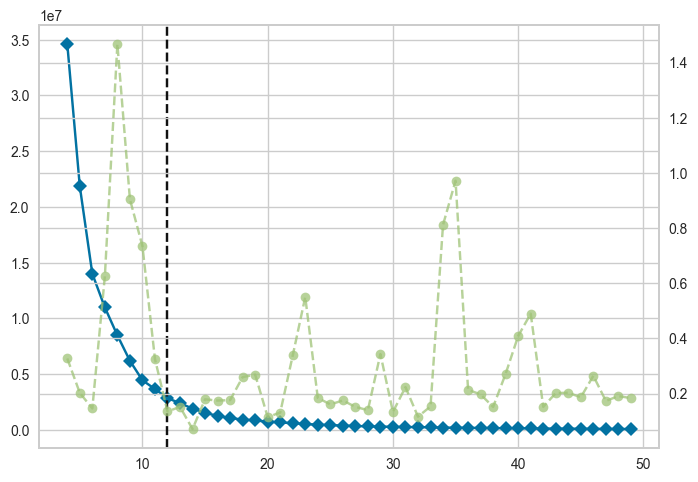

In [61]:
meal_plan_df = clusterize(
    meal_plan_df, 
    col_name_list=['meal_set_wt'], 
    k_range=(4, 50),
    cluster_name='serv_wt_cluster'
    )
meal_plan_df.head()

,plan_id,meal_set,recipe_name,energy,protein,total_serving_wt,meal_set_wt,meal_set_cal,meal_set_prot,cal_wt_ratio,prot_wt_ratio,serv_wt_cluster,cal_cluster
0,1,1,Dal Paratha,332.35,12.01,112.18,141.89,342.67,13.02,2.41504,0.091761,10,7
1,1,1,Green Chutney,10.32,1.01,29.71,141.89,342.67,13.02,2.41504,0.091761,10,7
2,1,2,Curd,150.00,17.62,150.00,1037.91,863.71,43.02,0.832163,0.041449,7,2
3,1,2,Mixed vegetable salad,75.96,1.85,151.35,1037.91,863.71,43.02,0.832163,0.041449,7,2
4,1,2,Khichri (moong dal),637.75,23.55,736.56,1037.91,863.71,43.02,0.832163,0.041449,7,2


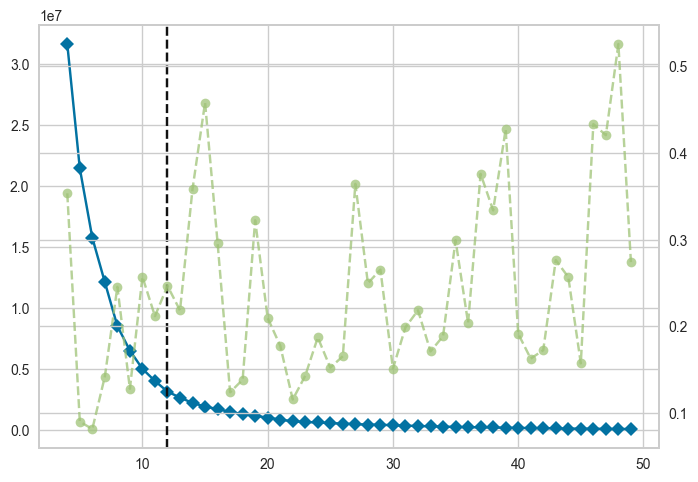

In [65]:
meal_plan_df = clusterize(
    meal_plan_df, 
    col_name_list=['meal_set_cal'], 
    k_range=(4, 50),
    cluster_name='cal_cluster'
    )
meal_plan_df.head()

,plan_id,meal_set,recipe_name,energy,protein,total_serving_wt,meal_set_wt,meal_set_cal,meal_set_prot,cal_wt_ratio,prot_wt_ratio,serv_wt_cluster,cal_cluster,cal_wt_ratio_cluster
0,1,1,Dal Paratha,332.35,12.01,112.18,141.89,342.67,13.02,2.41504,0.091761,10,7,8
1,1,1,Green Chutney,10.32,1.01,29.71,141.89,342.67,13.02,2.41504,0.091761,10,7,8
2,1,2,Curd,150.00,17.62,150.00,1037.91,863.71,43.02,0.832163,0.041449,7,2,6
3,1,2,Mixed vegetable salad,75.96,1.85,151.35,1037.91,863.71,43.02,0.832163,0.041449,7,2,6
4,1,2,Khichri (moong dal),637.75,23.55,736.56,1037.91,863.71,43.02,0.832163,0.041449,7,2,6


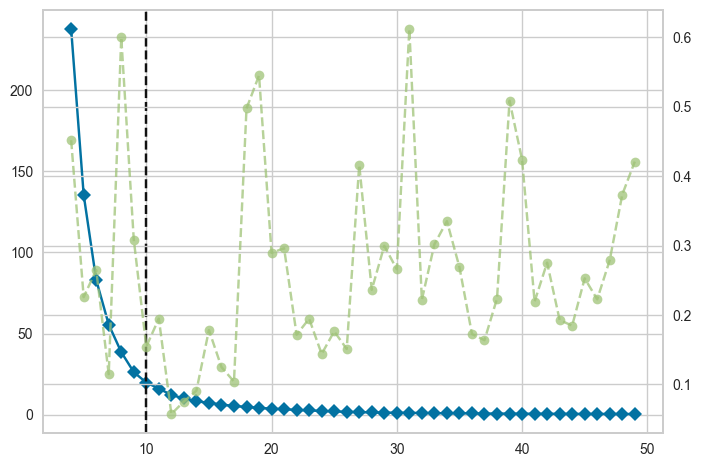

In [69]:
meal_plan_df = clusterize(
    meal_plan_df, 
    col_name_list=['cal_wt_ratio'], 
    k_range=(4, 50),
    cluster_name='cal_wt_ratio_cluster'
    )
meal_plan_df.head()

In [110]:
meal_plan_df.to_csv('clustered_meals.csv')